In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [4]:
# --- Core packages
import mne
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

# --- Complementary packages
import os
import sys
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA
import joblib
import seaborn as sns
from mne.stats import bootstrap_confidence_interval

# --- Local modules
from modules import *

# Display parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

---
# Paths

In [5]:
# Variables
sub_nb=1

In [6]:
# Path names
# -- root
root_path='/Volumes/T5_EVO/1-experiments/REPLAYSEQ/1-data_ICM'
# ---- Behavior
behavior_path=root_path+'/behavior'
behavior_sub=behavior_path+f'/sub-0{sub_nb}_2024-04-10_09h41.08.639_results.csv'

# ---- Epochs
full_sequences_path=root_path+f'/3-epochs_sequences/mne-bids-pipeline/sub-0{sub_nb}/meg'
items_path=root_path+f'/2-epochs_items/mne-bids-pipeline/sub-0{sub_nb}/meg'
# ------ fif path
seq_run_01_path=full_sequences_path+f'/sub-0{sub_nb}_task-reproduction_epo.fif'
items_epoch_path=items_path+f'/sub-0{sub_nb}_task-reproduction-epo.fif'

# -- Save plot path
save_path_local_plots=f'/Users/et/Documents/UNICOG/2-MEG_analysis/1-MEGSEQ/1-Results/subjects/sub-0{sub_nb}/plots'
save_path_volume_plots=f'/Volumes/T5_EVO/1-experiments/REPLAYSEQ/5-plots/sub-0{sub_nb}'
save_path_local_objects=f'/Users/et/Documents/UNICOG/2-MEG_analysis/1-MEGSEQ/1-Results/subjects/sub-0{sub_nb}/saved_objects'
save_path_volume_objects=f'/Volumes/T5_EVO/1-experiments/REPLAYSEQ/4-saved_objects/sub-0{sub_nb}'

---
# Prepare Data

In [7]:
# Formating behavioral dataFrame
metadata_sequences=format_metadata_sequences(behavior_sub)
metadata_items=format_metadata_items(behavior_sub)
# All Sequences Names
seq_names=list(metadata_sequences['sequenceName'].unique())

/Users/et/Documents/UNICOG/2-MEG_analysis/1-MEGSEQ/modules/behavioral_functions.py:42: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  set_seq=pd.unique(seq)
/Users/et/Documents/UNICOG/2-MEG_analysis/1-MEGSEQ/modules/behavioral_functions.py:42: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  set_seq=pd.unique(seq)
/Users/et/Documents/UNICOG/2-MEG_analysis/1-MEGSEQ/modules/behavioral_functions.py:42: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  set_seq=pd.unique(seq)
/Users/et/Documents/UNICOG/2-MEG_analysis/1-MEGSEQ/modules/behavioral_functions.py:42: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in

In [8]:
# -- Load Sequences epochs
# Retrieving Sequence-based epoching
epochs_sequences=mne.read_epochs(seq_run_01_path, preload=True)

# Add a relevant metadata Dataframe
epochs_sequences.metadata=metadata_sequences

Reading /Volumes/T5_EVO/1-experiments/REPLAYSEQ/1-data_ICM/3-epochs_sequences/mne-bids-pipeline/sub-01/meg/sub-01_task-reproduction_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...   12300.00 ms
        0 CTF compensation matrices available
Adding metadata with 58 columns
270 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 10 columns


In [ ]:
# -- Load Items epochs
# Load epochs
epochs_items= mne.read_epochs(items_epoch_path, preload=True)

# Replace the epochs_items.metadata
epochs_items.metadata=metadata_items

In [9]:
# Baselining
epochs_sequences.apply_baseline((-0.2,0))

Applying baseline correction (mode: mean)


Number of events,270
Events,Fixation: 270
Time range,-0.200 – 12.300 s
Baseline,-0.200 – 0.000 s


---

# Global Field Power per Sequence type

In [13]:
epochs_sequences.apply_hilbert(envelope=True)

Number of events,270
Events,Fixation: 270
Time range,-0.200 – 12.300 s
Baseline,-0.200 – 0.000 s


/var/folders/14/1wp2gs4s4k9094qkx6kvfvq00000gn/T/ipykernel_13478/29812627.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs_sequences.copy().average().plot()


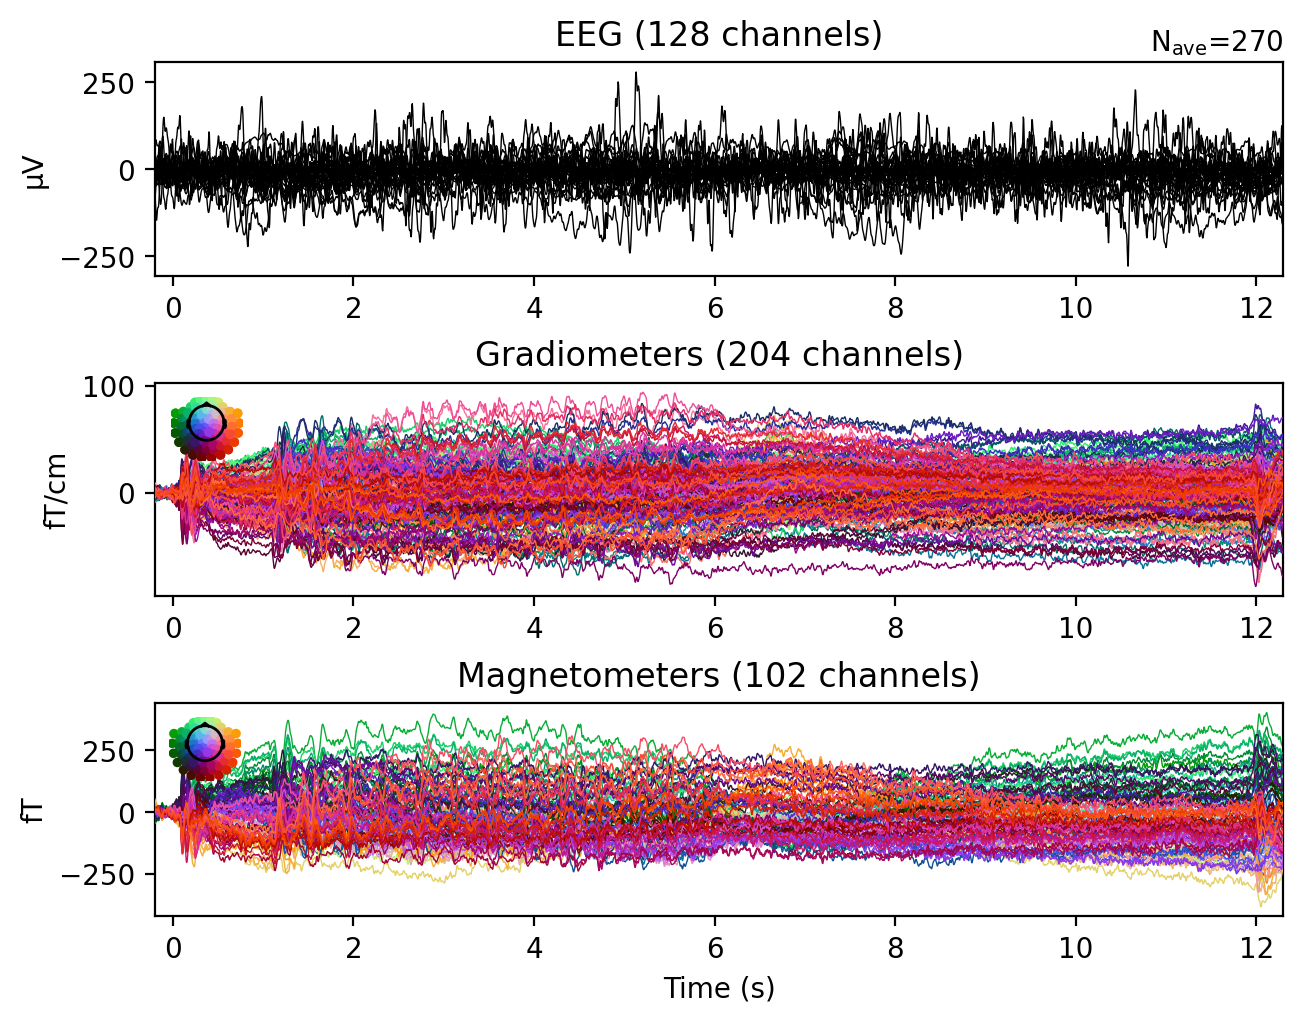

In [11]:
epochs_sequences.copy().average().plot()

In [10]:
# Get evoked response
evoked_sequences=[]
for i in range(9):
    evoked_sequences.append(epochs_sequences.copy()[epochs_sequences.metadata['sequenceName']==seq_names[i]].pick_types(meg='mag').average())

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [22]:
epochs_sequences.metadata.head(3)

,participant_number,block,trial,PresentedSequence,ProducedSequence,RTs,Performance,presentedStucture,presentedStuctureOrdinal,sequenceName
0,2,1,0,"[4, 5, 0, 3, 0, 5, 3, 4, 4, 3, 5, 0]","[4, 5, 0, 1, 4, 5, 0]","[3771487, 3772106, 3772808, 3776085, 3777489, ...",99,"[0, 1, 2, 3, 2, 1, 3, 0, 0, 3, 1, 2]","[A, B, C, D, C, B, D, A, A, D, B, C]",CRep4
1,2,1,1,"[5, 0, 1, 3, 1, 0, 3, 5, 5, 3, 0, 1]","[5, 0, 1, 2, 3, 1, 0, 5]","[3796488, 3797120, 3797696, 3798503, 3799587, ...",99,"[0, 1, 2, 3, 2, 1, 3, 0, 0, 3, 1, 2]","[A, B, C, D, C, B, D, A, A, D, B, C]",CRep4
2,2,1,2,"[5, 3, 2, 1, 2, 3, 1, 5, 5, 1, 3, 2]","[5, 3, 2, 1, 3, 1, 5]","[3820948, 3821573, 3822212, 3822889, 3824118, ...",99,"[0, 1, 2, 3, 2, 1, 3, 0, 0, 3, 1, 2]","[A, B, C, D, C, B, D, A, A, D, B, C]",CRep4


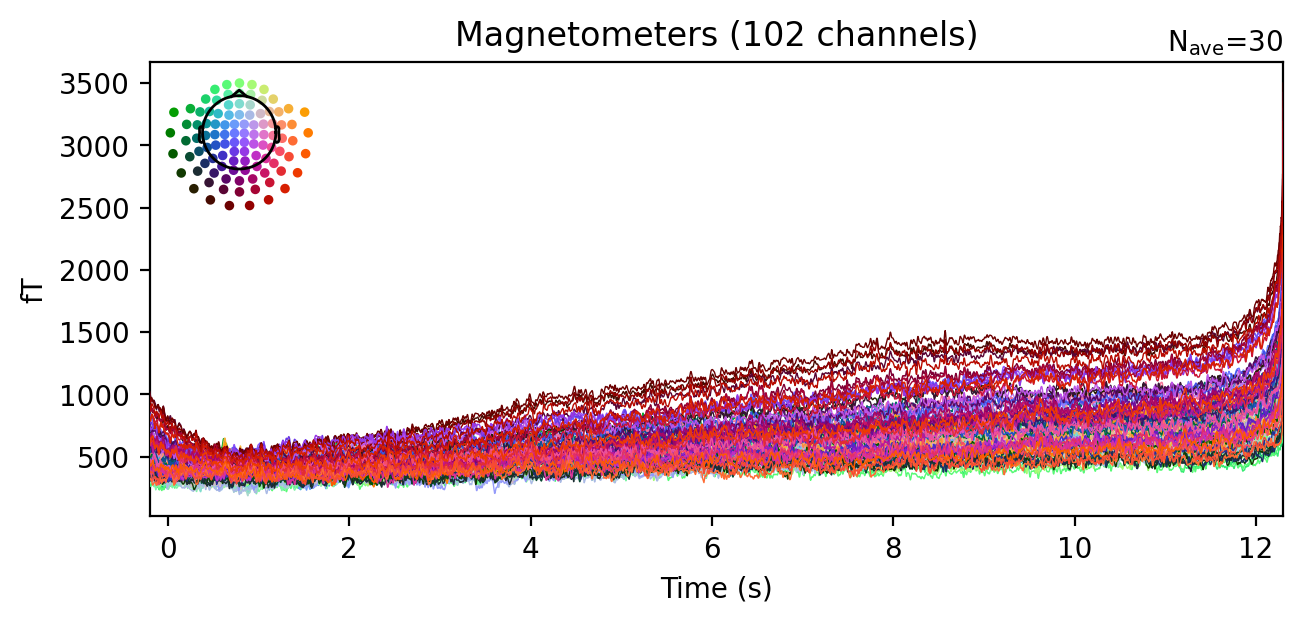

In [18]:
evoked_sequences[0].plot()

In [ ]:
fig, axes=plt.subplots(9,1,figsize=(20,7), sharex=True, sharey=True)
colors = plt.colormaps["summer_r"](np.linspace(0, 1, 9))
for color, ax in zip(colors,axes.ravel()[::-1]):
    times=